In [1]:
# Import the libraries
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Twitter API credentials
consumerKey = "7hiWTnn10uQFyredltX4LMBWg"
consumerSecret = "HdMkhR79IzrnGi51u2WgbPbcARXusKmBxFBnzuHgre08vYECrx"
accessToken = "1589215450163838976-Uz0MtuAXyrMVFLjnu2H3RLPcjMn5sr"
accessTokenSecret = "LFtU5hsrlgfPSTZPQHMxnPhjmj5QIPjeHk7ncFIVZbwcP"

In [3]:
# Create the authentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

#Set the access token and access token secret
authenticate.set_access_token(accessToken, accessTokenSecret)

#Create the API object 
api = tweepy.API(authenticate, wait_on_rate_limit = True)

In [4]:
#Extract 100 tweets from the Twitter user
posts = api.user_timeline(screen_name="BillGates", count=100, lang="en", tweet_mode="extended")

#Print the last 5 tweets from the user 
print("Show the 5 recent tweets: \n")
for tweet in posts[0:5]:
    print(tweet.full_text + "\n")

Unexpected parameter: lang


Forbidden: 403 Forbidden
453 - You currently have Essential access which includes access to Twitter API v2 endpoints only. If you need access to this endpoint, you’ll need to apply for Elevated access via the Developer Portal. You can learn more here: https://developer.twitter.com/en/docs/twitter-api/getting-started/about-twitter-api#v2-access-leve

# We failed to get the "Twitter Elevated Access," therefore, we'll be loading a dataset from Kaggle to analyse the sentiments assotiated with the tweets. This also makes the process longer because we'll have to pre-process the data. 

In [38]:
#Importing new libraries - because now we are not using Tweepy, TextBlob, and WordCloud
import seaborn as sns
import re
import string
import nltk
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset

In [8]:
data = pd.read_csv('twitter-data.csv')
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [14]:
# datatype info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


# Preprocessing the dataset

In [7]:
# removes pattern in the input text
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [12]:
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [18]:
#Removing Twitter handles (@user)
data['clean_tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*")

In [19]:
data.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


We have successfully removed twitter handles (@user) from the twitter dataset. 

In [20]:
# remove special characters, numbers and punctuations
data['clean_tweet'] = data['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
data.head()

/tmp/ipykernel_28320/2084551227.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['clean_tweet'] = data['clean_tweet'].str.replace("[^a-zA-Z#]", " ")


,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide society now #motivation


In [22]:
# individual words considered as tokens
tokenized_tweet = data['clean_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, a, father, is, dysfunctional, and, is, ...
1    [thanks, for, #lyft, credit, i, can, t, use, c...
2                              [bihday, your, majesty]
3    [#model, i, love, u, take, with, u, all, the, ...
4              [factsguide, society, now, #motivation]
Name: clean_tweet, dtype: object

In [23]:
# stem the words
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
tokenized_tweet.head()

0    [when, a, father, is, dysfunct, and, is, so, s...
1    [thank, for, #lyft, credit, i, can, t, use, ca...
2                              [bihday, your, majesti]
3    [#model, i, love, u, take, with, u, all, the, ...
4                    [factsguid, societi, now, #motiv]
Name: clean_tweet, dtype: object

In [24]:
# combine words into single sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
    
data['clean_tweet'] = tokenized_tweet
data.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunct and is so selfish he...
1,2,0,@user @user thanks for #lyft credit i can't us...,thank for #lyft credit i can t use caus they d...
2,3,0,bihday your majesty,bihday your majesti
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguid societi now #motiv


# Exploratory Data Analysis

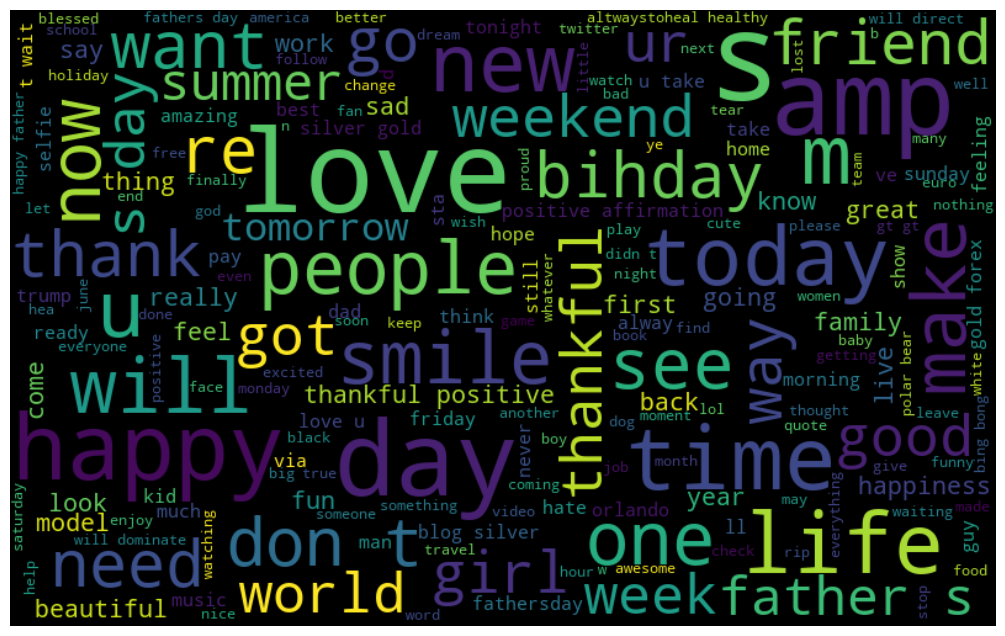

In [29]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in df['clean_tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

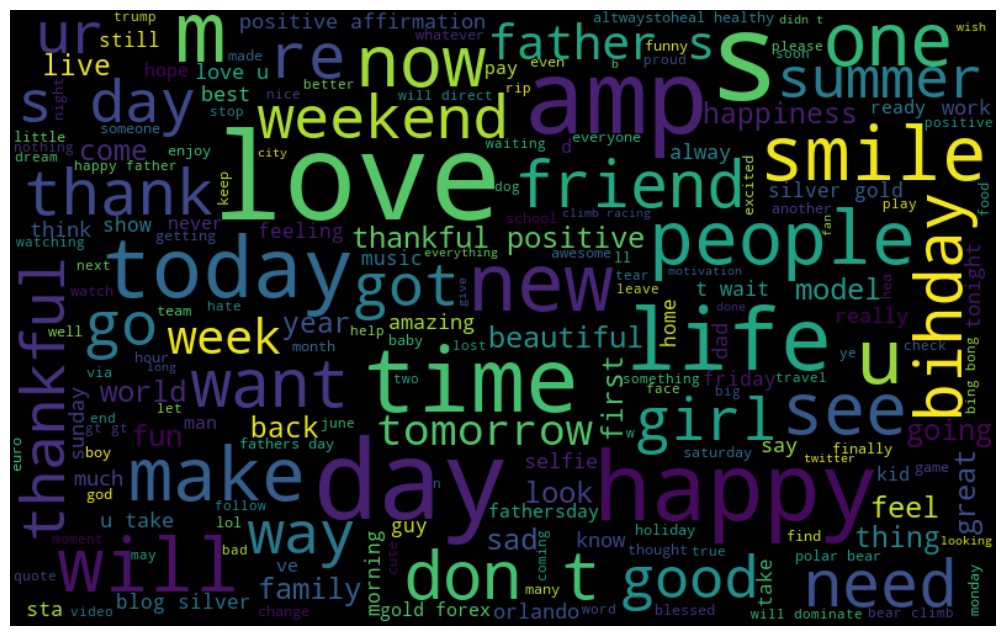

In [30]:
# frequent words visualization for +ve
all_words = " ".join([sentence for sentence in df['clean_tweet'][df['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

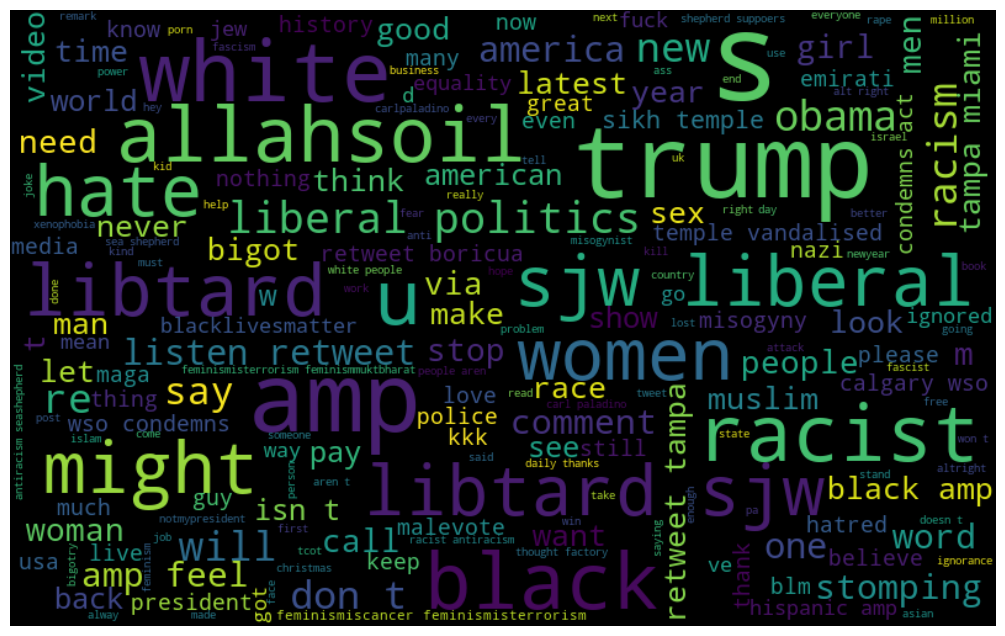

In [31]:
# frequent words visualization for -ve
all_words = " ".join([sentence for sentence in df['clean_tweet'][df['label']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [32]:
# extract the hashtag
def hashtag_extract(tweets):
    hashtags = []
    # loop words in the tweet
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)
    return hashtags    

In [33]:
# extract hashtags from non-racist/sexist tweets
ht_positive = hashtag_extract(df['clean_tweet'][df['label']==0])

# extract hashtags from racist/sexist tweets
ht_negative = hashtag_extract(df['clean_tweet'][df['label']==1])

In [34]:
ht_positive[:5]

[['run'], ['lyft', 'disapointed', 'getthanked'], [], ['model'], ['motivation']]

In [35]:
# unnest list
ht_positive = sum(ht_positive, [])
ht_negative = sum(ht_negative, [])

In [58]:
print(ht_negative[:5])
print(ht_positive[:5])

['cnn', 'michigan', 'tcot', 'australia', 'opkillingbay']
['run', 'lyft', 'disapointed', 'getthanked', 'model']


In [39]:
freq = nltk.FreqDist(ht_positive)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d.head()

,Hashtag,Count
0,run,34
1,lyft,2
2,disapointed,1
3,getthanked,2
4,model,365


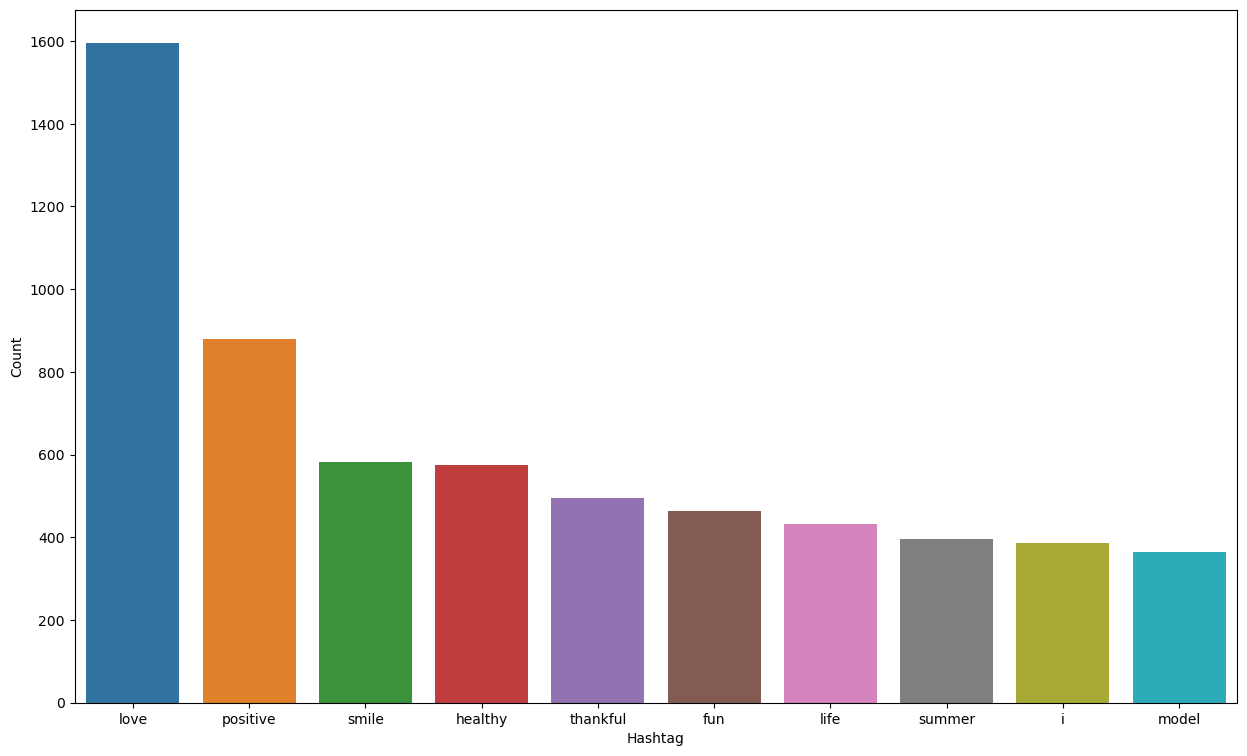

In [40]:
# select top 10 hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

In [41]:
freq = nltk.FreqDist(ht_negative)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d.head()

,Hashtag,Count
0,cnn,10
1,michigan,2
2,tcot,14
3,australia,6
4,opkillingbay,5


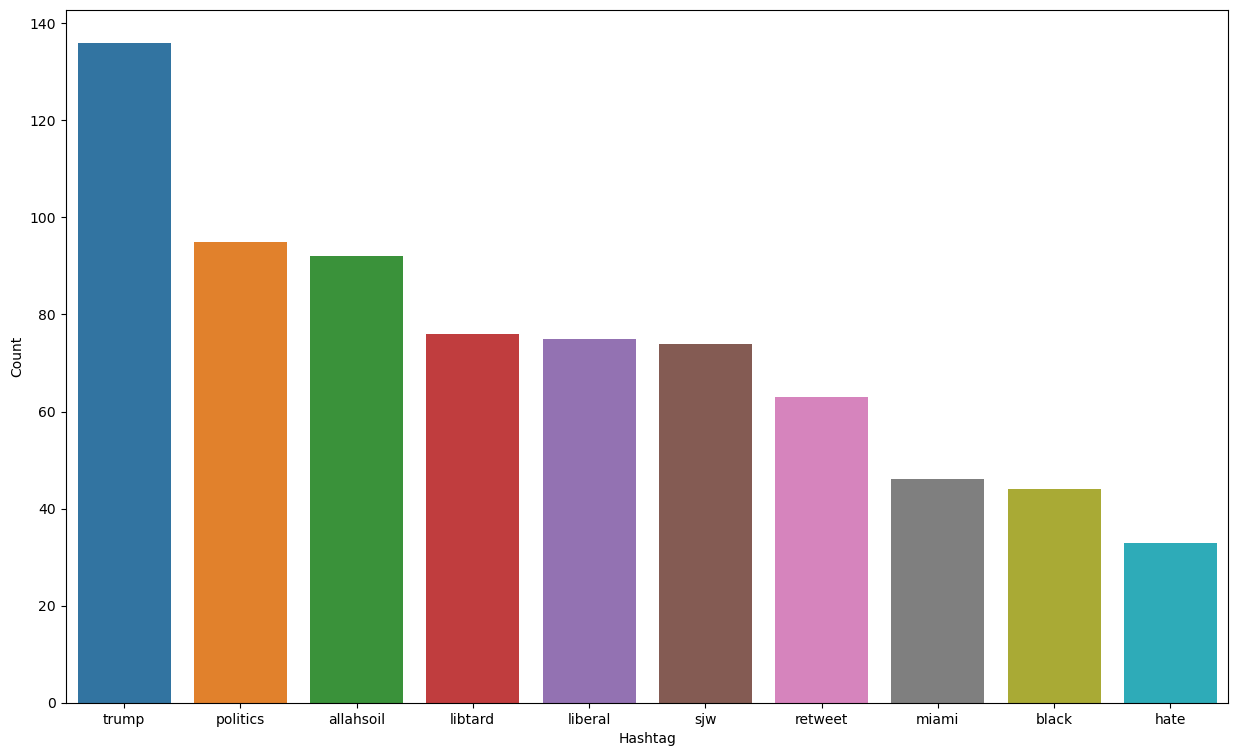

In [42]:
# select top 10 hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

# Input Split


In [43]:
# feature extraction
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df['clean_tweet'])

In [45]:
#bow[0].toarray()

In [46]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bow, df['label'], random_state=42, test_size=0.25)

# Model Training

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

In [48]:
# training
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [49]:
# testing
pred = model.predict(x_test)
f1_score(y_test, pred)

0.4711656441717791

In [50]:
accuracy_score(y_test,pred)

0.946064322362658